# Extracting discrete eye movements from continuous eye tracking data

This project formed part of my paper characterising the link between eye movements and neural network activity ([link](https://www.biorxiv.org/content/10.1101/2021.10.08.463476v1)).

Here, I process raw eye tracking data, in the form of x and y position recorded at 1 kHz, to identify when discrete eye movements ('saccades') occurred. Data is recorded while staring at the centre of a computer monitor when 4 images appear on the screen, one near each corner. The original data was collected by other researchers (available [here](https://crcns.org/data-sets/pfc/pfc-7/about-pfc-7)), and I have conducted the analysis of it. 

---
## Data import

First, lets load in the required modules and data. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes,InsetPosition,mark_inset)

eye_position = np.load('eyedata.npy')  # [dimensions (x/y) x trials x time (ms)]
trial_locations = np.load('eyedata.npy')  # vector of location of first cue on each trial

Now we need to normalise the data to make it easier to work with. This should always be done within each feature, as features can have dramatically different properties/statistics. So we'll do it seperately for the x and y dimensions. 

In [2]:
for i in range(2): 
    eye_position[i] -= np.mean(eye_position[i])
    eye_position[i] /= np.std(eye_position[i])

---
## Data exploration
Lets explore the data by visualising a random trial

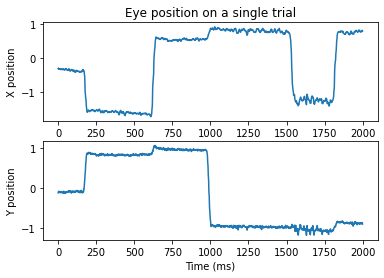

In [3]:
itrial = 9
eye_trial = eye_position[:, itrial]

f, (a0, a1) = plt.subplots(2, figsize=(6, 4))
a0.plot(eye_trial[0]);a1.plot(eye_trial[1]); a0.set_title('Eye position on a single trial')
a1.set_xlabel('Time (ms)');a0.set_ylabel('X position'); a1.set_ylabel('Y position');

Cool, we can see discrete shifts where the X and Y positions shoot off to different locations
This is because eye movements involve incredibly quick saccades, in the order of 10s of milliseconds!
Lets look at the 2D view of this.

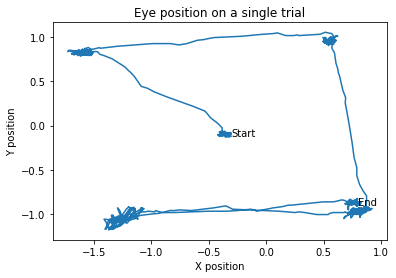

In [4]:
f = plt.figure(figsize=(6, 4))
plt.plot(*eye_trial); plt.title('Eye position on a single trial')
plt.xlabel('X position'); plt.ylabel('Y position'); 
plt.text(*eye_trial[:, 0], 'Start'); plt.text(*eye_trial[:, -1], 'End');

We can see they started at the centre of the screen, then looked at each cue in a clockwise direction starting at the top left (and looked back at the 3rd bottom right cue after viewing the 4th bottom left cue).

---

## Isolating saccades
Lets now isolate these discrete movements. First we'll calculate the instanteous speed of the eyes at each time point. To do this we calculate the distance between each consecutive pair of x and y positions. We can do this efficiently by calculating the L2 norm between the two vectors. 


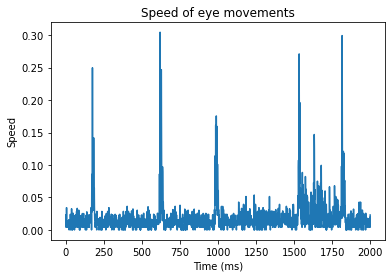

In [5]:
diff = eye_position[..., :-1] - eye_position[..., 1:]
speed = np.linalg.norm(diff, axis=0)

# Plot
speed_trial = np.copy(speed[itrial])
plt.plot(speed_trial); plt.xlabel('Time (ms)'); plt.ylabel('Speed')
plt.title('Speed of eye movements');

Cool, we can see five clear peaks corresponding to the 5 saccades we saw in the 2D plot. Lets detect these peaks using threshold crossing. We'll calculate the mean and standard deviation of the speed over the entire dataset, and use this to set a  threshold of two standard deviations above the mean.

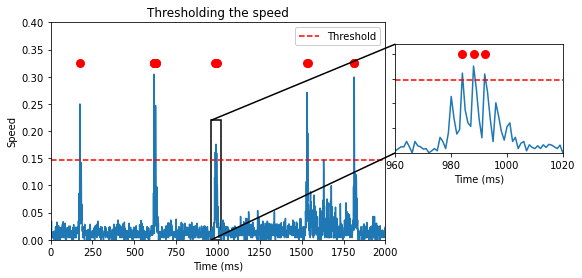

In [6]:
# Calculate threshold
threshold = np.mean(speed) + 2 * np.std(speed)

# Find where the data crossed the threshold
crosses = np.array(speed[itrial]>threshold,dtype=float)*0.325

# NaN out portions where no crosses occurred
crosses[crosses==0]=np.nan;

# Plot
f, ax=plt.subplots(1)
axins = ax.inset_axes([1.03, 0.4, 0.5, 0.5])
axins.set_yticklabels([])
for a in ax,axins:
    a.plot(speed_trial); a.axhline(threshold,ls='--',label='Threshold', c='red')
    a.scatter(range(len(crosses)), crosses, c='red', lw=3)
    a.set_xlabel('Time (ms)')
axins.scatter(range(len(crosses)), crosses-0.125, c='red', lw=3)
ax.set_ylim(0,0.4); axins.set_ylim(0,0.22); ax.set_ylabel('Speed');
ax.set_xlim(0, 2000);axins.set_xlim(960, 1020);
ax.set_title('Thresholding the speed');plt.legend(framealpha=1, loc='upper right'); 
mark_inset(ax, axins, loc1=2, loc2=3, ec="k", lw=1.5,alpha=1);

The threshold has nicely identified our five peaks. But when we zoom in we can see we actually have noise in the data causing multiple detections for the same event. This is caused by [50 Hz line noise](https://en.wikipedia.org/wiki/Mains_hum) in the recording equipment caused by our AC power supplies - notice how it is oscillates every 5 ms. Lets smooth our data to remove this noise. We will use a Gaussian kernel to smooth it which reliably increases our signal-to-noise ratio. 

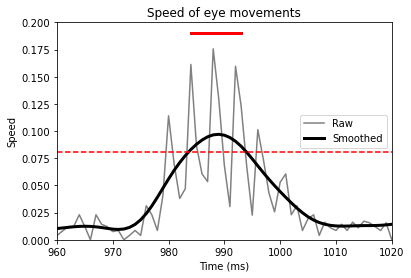

In [7]:
# Smooth data
speed = scipy.ndimage.gaussian_filter1d(speed, 3, axis=1)

# Re-calculate threshold on the smoothed data
threshold = np.mean(speed) + 1.5 * np.std(speed)

# Plot
plt.plot(speed_trial, label='Raw', c='gray'); 
plt.plot(speed[itrial], lw=3, label='Smoothed', c='k'); plt.axhline(threshold,ls='--', c='red')
plt.xlabel('Time (ms)'); plt.ylabel('Speed');plt.title('Speed of eye movements'); 
crosses = np.array(speed[itrial]>threshold,dtype=float)*0.19
crosses[crosses==0]=np.nan; plt.plot(crosses, c='red', lw=3)
plt.legend(); plt.xlim(960, 1020); plt.ylim(0, 0.2);

Great, now for each saccade we have one continuous period where the speed is above the threshold. Now lets extract the start of these events. We can do this efficiently by using a boolean array indicating points above the threshold, and calculating the difference between each consecutive point. Anywhere with a difference of '1' is where the speed crossed from below to above the threshold. 

Note, we'll take advantage of numpy's array indexing to perform this operation across all trials simultaneously.

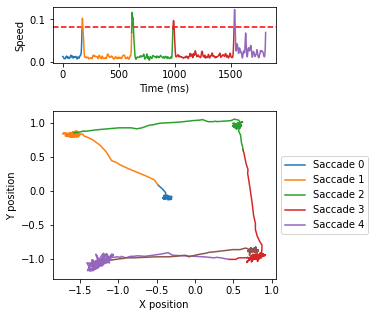

In [8]:
# Find all instances where speed crossed the threshold
trial_crosses = np.array(speed[itrial]>threshold, dtype=float)

# Find instances where the speed went from below to above the threshold
start_of_crosses = np.diff(trial_crosses) == 1  

# Get timestamp of these crossings
time_of_crosses = np.where(start_of_crosses)[0]

#% Plot
f, (a0, _, a1) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [1, 0.3, 3]}, figsize=(4, 5))
_.axis('off');a0.set_xlabel('Time (ms)'); a0.set_ylabel('Speed');
a0.axhline(threshold,ls='--',label='Threshold', c='red')
time_of_crosses = np.hstack((0, time_of_crosses))
for i in range(len(time_of_crosses)-1):
    a0.plot(range(time_of_crosses[i], time_of_crosses[i+1]+1), speed[itrial, time_of_crosses[i]:time_of_crosses[i+1]+1]); 
    a1.plot(*eye_trial[:, time_of_crosses[i]:time_of_crosses[i+1]+1], label=f'Saccade {i}')
a1.plot(*eye_trial[:, time_of_crosses[i+1]:-1])
a1.set_xlabel('X position'); a1.set_ylabel('Y position'); a1.legend(loc='center left', bbox_to_anchor=[1,0.5]);

Perfect, our data is now nicely split into the five different saccades that occurred. Each colour indicates an identified saccade. We can see everytime the colour changes is when the eye position shoots off to another part of the screen. 

Now we can actually start analysing the eye data over trials. For example, lets compute the reaction time for the first saccade. 

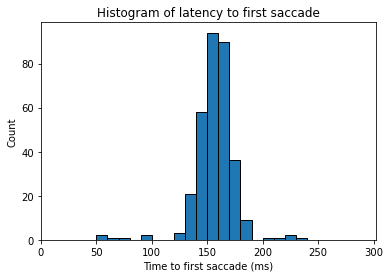

In [9]:
all_crosses = np.array(speed>threshold, dtype=float)
start_of_crosses = np.diff(all_crosses) == 1  
time_of_crosses = np.argmax(start_of_crosses, axis=1)

# Plot
plt.hist(time_of_crosses, bins=np.arange(50, 300, 10),  edgecolor='black'); 
plt.xlabel('Time to first saccade (ms)');plt.ylabel('Count');
plt.title('Histogram of latency to first saccade'); plt.xlim(0);

We can see that it took an average of only ~160 ms for the first saccade to occur, which is an impressively quick reaction time! 

Now we're ready to see what neurons are doing during these eye movements (see my other projects).